# Microlensing Effect Example

In this notebook we look at how we can apply a simple microlensing effect that wraps the [VBMicrolensing package](https://github.com/valboz/VBMicrolensing).  

Note that the VBMicrolensing package is not installed as part of the default TDAstro installation. Users will need to manually install VBMicrolensing via pip (e.g. `pip install VBMicrolensing`) in order to run this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.effects.microlensing import Microlensing
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.sources.basic_sources import StaticSource, SinWaveSource
from tdastro.sources.lightcurve_template_model import LightcurveTemplateModel
from tdastro.utils.plotting import plot_lightcurves


# Usually we would not hardcode the path to the passband files, but for this demo we will use a relative path
# to the test data directory so that we do not have to download the files.
data_dir = Path("../../tests/tdastro/data")

## Basic Application

In the most basic form, the microlensing effect can be added to any source. Here we start with a static source with no microlensing.

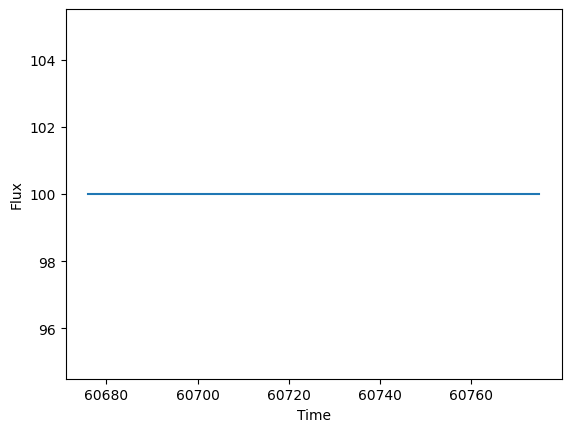

In [2]:
source = StaticSource(brightness=100.0)

t_start = 60676.0
times = np.arange(100.0) + t_start
wavelengths = np.array([7000.0])
fluxes = source.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

Now we add a microlensing effect.  As you can see, the microlensing introduces a magnification 20.0 days after the start of the light curve.

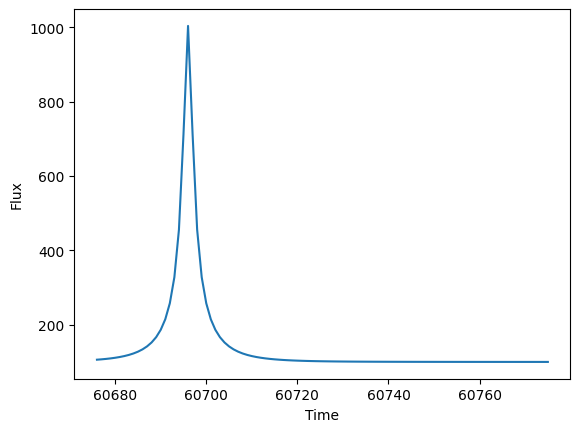

In [3]:
ml_effect = Microlensing(microlensing_t0=t_start + 20.0, u_0=0.1, t_E=10.0)
source.add_effect(ml_effect)

fluxes = source.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

The model underneath the microlense does not need to be constant. We could simulate a small amount of variability by using a sin wave based model.

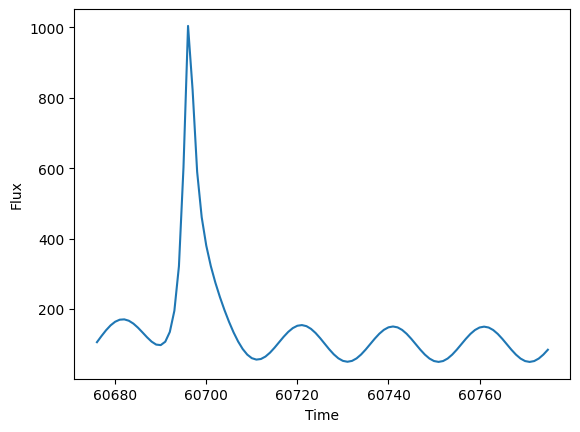

In [4]:
source2 = SinWaveSource(brightness=100.0, amplitude=50.0, frequency=0.05, t0=t_start)
source2.add_effect(ml_effect)
fluxes = source2.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## More Complex Models

We can extend the microlensing effect with any one of our SED or bandflux based models. For example consider a `LightcurveModel` which takes sample data points in each bandflux and returns the interpolated values.

We start by loading passbands, which are needed from the lightcurve model. Here we use (potentially older) data from the test directory to avoid needing to do a download. Users will generally want to download the most recent passbands. See the passbands notebook for more details.

In [5]:
# Load the passband data for the griz filters only.
filters = ["g", "r", "i", "z"]
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters=filters,
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=data_dir / "passbands",
)

2025-08-25 10:37:22,627 - INFO - Loading passbands from preset LSST
2025-08-25 10:37:22,628 - INFO - Data file ../../tests/tdastro/data/passbands/LSST/u.dat already exists. Skipping download.
2025-08-25 10:37:22,629 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/u.dat
2025-08-25 10:37:22,634 - INFO - Data file ../../tests/tdastro/data/passbands/LSST/g.dat already exists. Skipping download.
2025-08-25 10:37:22,634 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/g.dat
2025-08-25 10:37:22,638 - INFO - Data file ../../tests/tdastro/data/passbands/LSST/r.dat already exists. Skipping download.
2025-08-25 10:37:22,638 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/r.dat
2025-08-25 10:37:22,642 - INFO - Data file ../../tests/tdastro/data/passbands/LSST/i.dat already exists. Skipping download.
2025-08-25 10:37:22,642 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/i.dat
2025-08-

Next we define a series of lightcurves to use as our background source.  These will be defined for the griz filters.

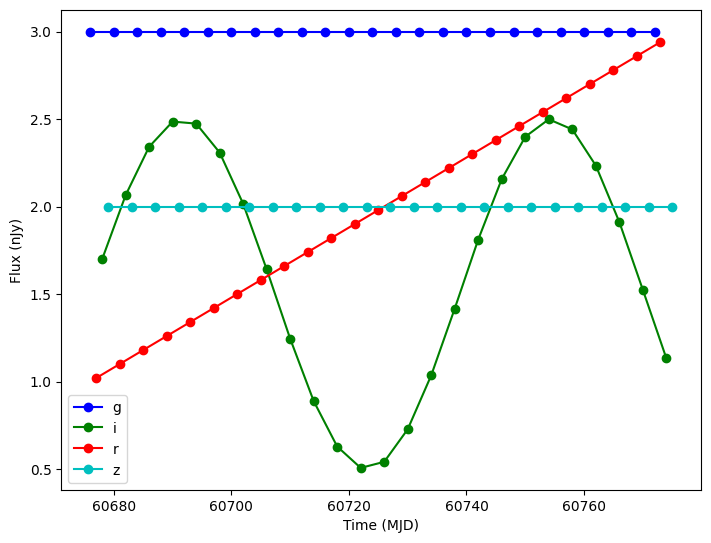

In [6]:
dts = np.arange(100.0)
times = dts + t_start

lightcurves = {
    "g": np.array([times, 3.0 * np.ones_like(times)]).T,  # Constant at 3.0
    "r": np.array([times, 0.02 * dts + 1.0]).T,  # Slight linear increase
    "i": np.array([times, np.sin(dts / 10.0) + 1.5]).T,  # Sin wave
    "z": np.array([times, 2.0 * np.ones_like(times)]).T,  # Constant at 2.0
}

lc_source = LightcurveTemplateModel(lightcurves, passband_group, t0=0)
graph_state = lc_source.sample_parameters(num_samples=1)

query_filters = np.array([filters[i % 4] for i in range(len(times))])
fluxes = lc_source.evaluate_bandfluxes(passband_group, times, query_filters, graph_state)

plot_lightcurves(fluxes, times, fluxerrs=None, filters=query_filters)

We can add microlensing to this source model as we would any other model.

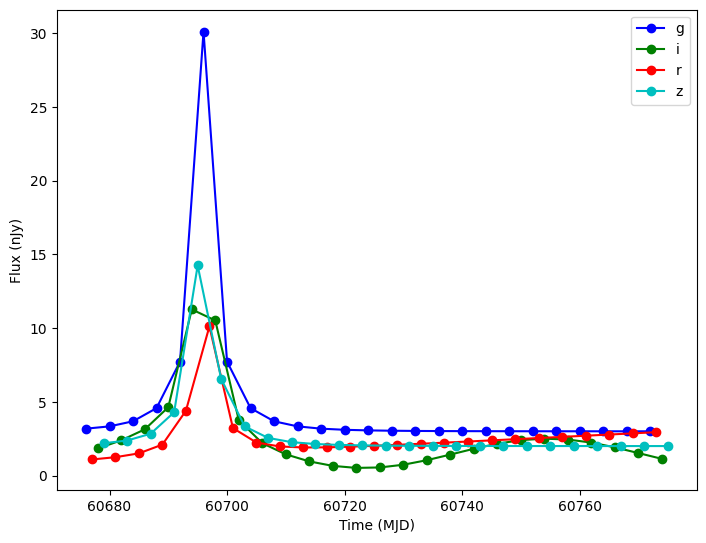

In [7]:
lc_source.add_effect(ml_effect)

# We need to resample to include the effect’s parameters.
graph_state = lc_source.sample_parameters(num_samples=1)
fluxes = lc_source.evaluate_bandfluxes(passband_group, times, query_filters, graph_state)

plot_lightcurves(fluxes, times, fluxerrs=None, filters=query_filters)

## Varying the Microlensing Parameters

The main parameters of the microlensing model (`microlensing_t0`, `u_0`, and `t_E`) can be set like any other sample-able parameter. For example, let’s draw the start time uniformly from [60686.0, 60700.0], `u_0` from a normal centered on 0.1, and `t_E` from a normal centered on 20.0. We can then draw 10 samples and see how they vary.

In [8]:
source = StaticSource(brightness=100.0, node_label="source")

ml_effect = Microlensing(
    microlensing_t0=NumpyRandomFunc("uniform", low=60686.0, high=60700.0),
    u_0=NumpyRandomFunc("normal", loc=0.1, scale=0.01),
    t_E=NumpyRandomFunc("normal", loc=20.0, scale=3.0),
)
source.add_effect(ml_effect)

state = source.sample_parameters(num_samples=5)

print("T0:", state["source"]["microlensing_t0"])
print("u_0:", state["source"]["u_0"])
print("t_E:", state["source"]["t_E"])

T0: [60687.8343985  60692.74911519 60693.51624808 60694.56712289
 60697.60756462]
u_0: [0.10520894 0.1137816  0.09365502 0.10240146 0.10396902]
t_E: [19.69195313 22.96530755 19.41982746 16.05762578 26.39363185]


And we can plot the first few curves.  Notice how the timing and shape of the lensing event varies.

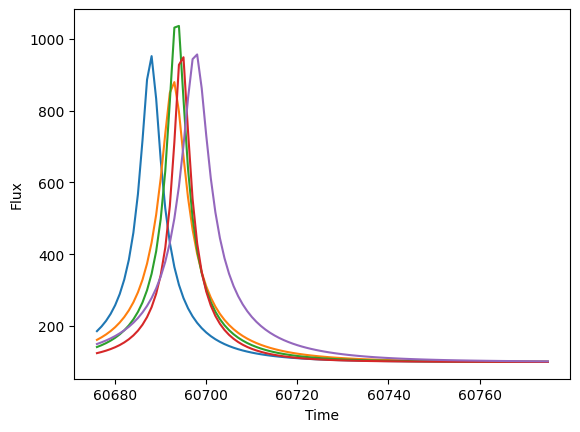

In [9]:
fluxes = source.evaluate_sed(times, wavelengths, graph_state=state)

for i in range(5):
    plt.plot(times, fluxes[i, :, 0])
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## Probabilistically Applying Microlensing

The microlensing effect also includes the ability to probabilistically apply the effect to only a subset of the lightcurves. This is useful if you want a random 1 in every 10,000 stars to be microlensed.  The probability is controlled via the `probability` parameter.

In the below example, only 50% of the samples will have the microlensing applied. The sources with microlensing are shown in red and the sources without it are shown in blue. 

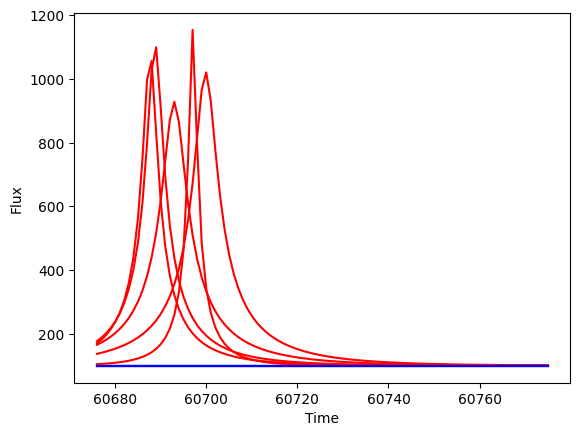

In [10]:
source = StaticSource(brightness=100.0, node_label="source")

ml_effect = Microlensing(
    microlensing_t0=NumpyRandomFunc("uniform", low=60686.0, high=60700.0),
    u_0=NumpyRandomFunc("normal", loc=0.1, scale=0.01),
    t_E=NumpyRandomFunc("normal", loc=20.0, scale=3.0),
    probability=0.5,
)
source.add_effect(ml_effect)

state = source.sample_parameters(num_samples=10)
fluxes = source.evaluate_sed(times, wavelengths, graph_state=state)
for i in range(10):
    if state["source"]["apply_microlensing"][i]:
        plt.plot(times, fluxes[i, :, 0], color="red")
    else:
        plt.plot(times, fluxes[i, :, 0], color="blue")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## Blended Models

For a more realistic simulation, let us consider the combination of two different sources of flux:

  * **Source** - The source that is being microlensed. This flux will be magnified by the lense.
  * **Blends** - The flux coming from the background (or maybe the lense itself)

The structure of this model is shown in the following illustration:

![An example sampling graph](../_static/MicrolensingGraph.png "Sampling Graph")

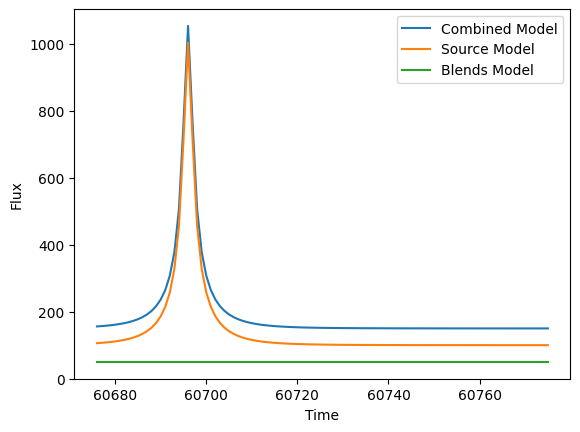

In [11]:
from tdastro.sources.multi_source_model import AdditiveMultiSourceModel

# Create the blends.
blends = StaticSource(brightness=50.0, node_label="blends")

# Create the source and add the lensing effect.
source = StaticSource(brightness=100.0, node_label="source")
ml_effect = Microlensing(microlensing_t0=t_start + 20.0, u_0=0.1, t_E=10.0)
source.add_effect(ml_effect)

# The full model is the sum of all three flux sources.
model = AdditiveMultiSourceModel([source, blends])

# Evaluate the combined model at different times.
fluxes_all = model.evaluate_sed(times, wavelengths)
fluxes_source = source.evaluate_sed(times, wavelengths)
fluxes_blends = blends.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes_all, label="Combined Model")
plt.plot(times, fluxes_source, label="Source Model")
plt.plot(times, fluxes_blends, label="Blends Model")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

As we can see from the graph, in this example, the microlensing magnification was only applied to the source.